In [86]:
import numpy as np 
import pandas as pd
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix, accuracy_score


In [2]:
from imblearn.over_sampling import SMOTE

In [129]:
df_load = pd.read_excel('MM_genetik.xlsx')

In [4]:
df = df_load.copy()
df.head(10)

In [5]:
df.shape

(233, 11)

In [6]:
round(df['Age'].mean(),1)

64.6

In [7]:
df = df.drop(columns=['Kariotyp'])

In [9]:
df['Nr.'] = df['Nr.'].astype(str)
df['FISH'] = df['FISH'].astype(str)
df['FISH'] = df['FISH'].apply(lambda x: re.sub(r'HD:', '', x))
df['NGS'] = df['NGS'].astype(str)
df.head(10)

,Nr.,Age,DS,S/D,ISS,ISS-R,IgG expression,plasmacells Infiltration,FISH,NGS
0,18,76,MM,NaN,II,III,LK kappa,50,"t(14;16),+1q(x3),del(13q14)",wt
1,22,65,MM,IIIA,II,II,LK kappa,75,"+9q34,+11q23,+15q22,+19q13,del(17p13)",KRAS
2,24,57,MM,II,I,III,LK kappa,30,"t(11;14),+1q(x3),del(13q)",KRAS
3,26,55,MM,IIIA,I,III,IgA kappa,80,"t(4;14),del(13q14),+1q21(>3),+5,+8,+9,+11,+15,...",wt
4,27,71,MM,IIIA,I,I,IgG lambda,20,"+9,+11,+15,+19",wt
5,29,81,MM,III,I,I,IgA kappa,15,normal,wt
6,30,47,MM,NaN,II,II,IgG kappa,80,normal,TP53
7,33,57,MM,II,III,III,IgG kappa,NaN,normal,RUNX1
8,34,57,MM,IIIB,III,III,IgG lambda,90,"t(4;14),del(13q14),del(17p13),+1q21(<3),+9q3, ...","TP53, TET2"
9,36,78,MM,NaN,II,II,LK kappa,50,"IgH-rear, t(?;IgH),+1q21(x3)",wt


In [10]:
df1 = df[['FISH']].assign(FISH_expl=df['FISH'].str.lower().str.split(',').apply(lambda x: [i.strip() for i in x]))
df1.head(10)

,FISH,FISH_expl
0,"t(14;16),+1q(x3),del(13q14)","[t(14;16), +1q(x3), del(13q14)]"
1,"+9q34,+11q23,+15q22,+19q13,del(17p13)","[+9q34, +11q23, +15q22, +19q13, del(17p13)]"
2,"t(11;14),+1q(x3),del(13q)","[t(11;14), +1q(x3), del(13q)]"
3,"t(4;14),del(13q14),+1q21(>3),+5,+8,+9,+11,+15,...","[t(4;14), del(13q14), +1q21(>3), +5, +8, +9, +..."
4,"+9,+11,+15,+19","[+9, +11, +15, +19]"
5,normal,[normal]
6,normal,[normal]
7,normal,[normal]
8,"t(4;14),del(13q14),del(17p13),+1q21(<3),+9q3, ...","[t(4;14), del(13q14), del(17p13), +1q21(<3), +..."
9,"IgH-rear, t(?;IgH),+1q21(x3)","[igh-rear, t(?;igh), +1q21(x3)]"


In [11]:
df1 = df1.explode('FISH_expl')

In [12]:
df1.head(10)

,FISH,FISH_expl
0,"t(14;16),+1q(x3),del(13q14)",t(14;16)
0,"t(14;16),+1q(x3),del(13q14)",+1q(x3)
0,"t(14;16),+1q(x3),del(13q14)",del(13q14)
1,"+9q34,+11q23,+15q22,+19q13,del(17p13)",+9q34
1,"+9q34,+11q23,+15q22,+19q13,del(17p13)",+11q23
1,"+9q34,+11q23,+15q22,+19q13,del(17p13)",+15q22
1,"+9q34,+11q23,+15q22,+19q13,del(17p13)",+19q13
1,"+9q34,+11q23,+15q22,+19q13,del(17p13)",del(17p13)
2,"t(11;14),+1q(x3),del(13q)",t(11;14)
2,"t(11;14),+1q(x3),del(13q)",+1q(x3)


In [13]:
same = {
    'del(17p13)': 'del(17p)',
    'del(13q14)': 'del(13q)',
    'del(14q32)': 'del(igh)',
    '-igh': 'del(igh)',
    '+myc (8q24)': '+myc',
     'myc-amplif': '+myc',
    '+8(myc)': '+myc',
    '17p-': 'del(17p)',
    'del(19q13)': 'del(19q)',
    'del(1q32)': 'del(1q)',
    'del(1p21)': 'del(1p)',
    'del(4p16)': 'del(fgfr3)',
    'del(1p32)': 'del(1p)',
    'del(16q23)': 'del(maf)',
    '+1q21(x3)': '+1q(x3)',
    '+1q21(>3)': '+1q(>3)',
    '+1q21(?)': '+1q21',
    '+1q21(<3)': '+1q21',
    '13q-': 'del(13q)',
    '-myc': 'del(myc)',
    '1q(x3)': '+1q(x3)',
    '1q(>3)': '+1q(>3)',
    '+1q(3)': '+1q(x3)',
    '+11q23': '+11',
    '+19q13': '+19',
    '+9q34': '+9',
    '+15q22': '+15',
    '+1q21': '+1q',
    '+8q24': '+myc',
    '+1q': '+1q(x3)',
    '+11q': '+11',
    'del(8p21)': 'del(8p)',
    'del(11q23)': 'del(11q)',
    '+11q13': '+11',
    '+17p13': '+17',
    '+9q3': '+9',
    '+13q34': '+13',
    '+1p32': '+1p',
    '+16q23': '+16',
    '+15q': '+15',
    '+19q': '+19'
}

In [14]:
df1.FISH_expl = df1.FISH_expl.replace(same)

In [15]:
#iterative improvement
pd.set_option("display.max_rows", None)
df1.FISH_expl.value_counts()

FISH_expl
+19           82
+11           80
+9            75
+15           62
+1q(x3)       60
del(13q)      59
t(11;14)      47
del(17p)      28
del(igh)      28
+1q(>3)       26
+17           22
igh-rear      22
normal        21
t(4;14)       21
t(igh;?)      20
myc-rear      19
del(1p)       16
+8            15
+4            13
+myc          12
+1p            9
del(maf)       8
t(14;16)       7
+5             6
del(myc)       4
t(14;20)       4
t(?;igh)       4
+16            3
+14            3
del(8p)        3
del(fgfr3)     3
+1q            2
t(?:igh)       2
nan            2
+13            2
del(13)        2
+igh           2
-13            2
del(19q)       2
del(11q)       2
+1q21          2
myc            1
5721198        1
lb 5711711     1
+21            1
del(14)        1
del(8)         1
del(11q22)     1
t(myc;?)       1
del(14q14)     1
t(4;11)        1
-1             1
+6             1
del(7)         1
+20            1
del(1q)        1
del(16q)       1
t(?;14)        1
del(

In [16]:
df1.FISH_expl.nunique()

61

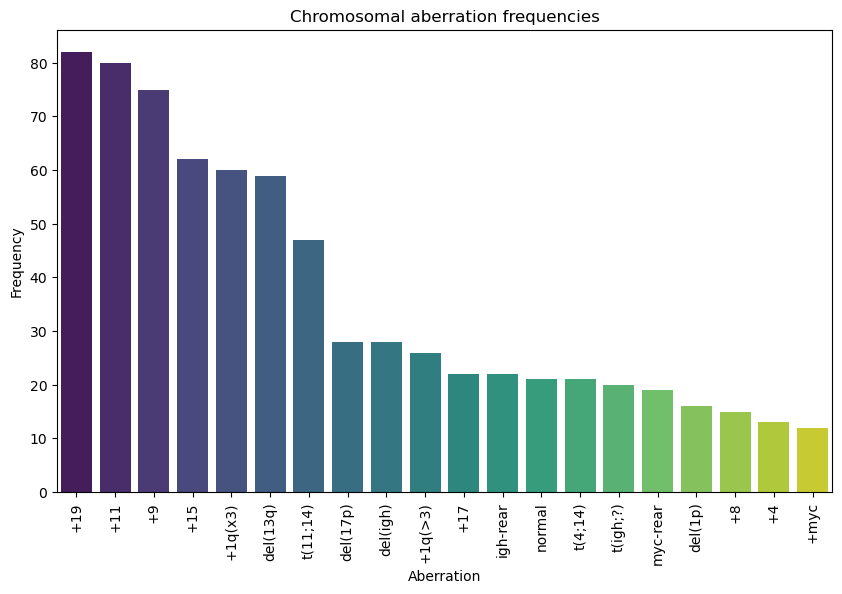

In [17]:
fish = df1.FISH_expl.value_counts()[:20]
fish = fish.reset_index()
fish.columns = ['a', 'f']

plt.figure(figsize=(10, 6))  
sns.barplot(x='a', y='f', data=fish, palette='viridis')

plt.title('Chromosomal aberration frequencies')
plt.xlabel('Aberration')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()



In [18]:
df2 = df[['NGS']].assign(NGS_expl=df['NGS'].str.lower().str.split(',').apply(lambda x: [i.strip() for i in x]))
df2

,NGS,NGS_expl
0,wt,[wt]
1,KRAS,[kras]
2,KRAS,[kras]
3,wt,[wt]
4,wt,[wt]
5,wt,[wt]
6,TP53,[tp53]
7,RUNX1,[runx1]
8,"TP53, TET2","[tp53, tet2]"
9,wt,[wt]


In [19]:
df2

,NGS,NGS_expl
0,wt,[wt]
1,KRAS,[kras]
2,KRAS,[kras]
3,wt,[wt]
4,wt,[wt]
5,wt,[wt]
6,TP53,[tp53]
7,RUNX1,[runx1]
8,"TP53, TET2","[tp53, tet2]"
9,wt,[wt]


In [20]:
df2 = df2.explode('NGS_expl')

In [21]:
df2.head(10)

,NGS,NGS_expl
0,wt,wt
1,KRAS,kras
2,KRAS,kras
3,wt,wt
4,wt,wt
5,wt,wt
6,TP53,tp53
7,RUNX1,runx1
8,"TP53, TET2",tp53
8,"TP53, TET2",tet2


In [22]:
#iterative improvement
df2.NGS_expl.value_counts()

NGS_expl
wt        101
kras       35
tp53       31
dnmt3a     29
nras       27
tet2       16
asxl1       9
braf        7
runx1       6
sf3b1       4
rb1         4
cebpa       3
nf1         3
kdm6a       3
myd88       2
rad21       2
srsf2       2
idh2        2
ptpn11      2
stag2       2
cbl         2
ezh2        1
myc         1
smc1a       1
bcorl1      1
cdkn2a      1
setb1       1
ddx4        1
hras        1
bcor        1
idh1        1
zrsr2       1
jak2        1
bcorl       1
flt3        1
Name: count, dtype: int64

In [23]:
df2.NGS_expl.nunique()

35

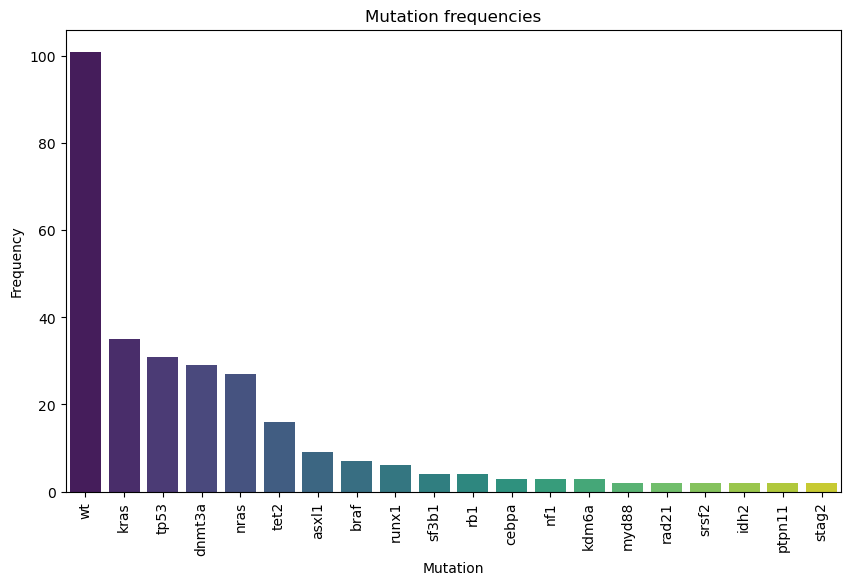

In [24]:
ngs = df2.NGS_expl.value_counts()[0:20]
ngs = ngs.reset_index()
ngs.columns = ['g', 'f']

plt.figure(figsize=(10, 6))  
sns.barplot(x='g', y='f', data=ngs, palette='viridis')

plt.title('Mutation frequencies')
plt.xlabel('Mutation')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


In [25]:
value_counts_df1 = df1['FISH_expl'].value_counts()
filtered_df1 = df1[df1['FISH_expl'].isin(value_counts_df1[value_counts_df1 > 7].index)]
filtered_df1

,FISH,FISH_expl
0,"t(14;16),+1q(x3),del(13q14)",+1q(x3)
0,"t(14;16),+1q(x3),del(13q14)",del(13q)
1,"+9q34,+11q23,+15q22,+19q13,del(17p13)",+9
1,"+9q34,+11q23,+15q22,+19q13,del(17p13)",+11
1,"+9q34,+11q23,+15q22,+19q13,del(17p13)",+15
1,"+9q34,+11q23,+15q22,+19q13,del(17p13)",+19
1,"+9q34,+11q23,+15q22,+19q13,del(17p13)",del(17p)
2,"t(11;14),+1q(x3),del(13q)",t(11;14)
2,"t(11;14),+1q(x3),del(13q)",+1q(x3)
2,"t(11;14),+1q(x3),del(13q)",del(13q)


In [26]:
value_counts_df2 = df2['NGS_expl'].value_counts()
filtered_df2 = df2[df2['NGS_expl'].isin(value_counts_df2[value_counts_df2 > 3].index)]
filtered_df2

,NGS,NGS_expl
0,wt,wt
1,KRAS,kras
2,KRAS,kras
3,wt,wt
4,wt,wt
5,wt,wt
6,TP53,tp53
7,RUNX1,runx1
8,"TP53, TET2",tp53
8,"TP53, TET2",tet2


In [27]:
mat1_filtered = pd.get_dummies(filtered_df1['FISH_expl']).astype(bool).groupby(filtered_df1.index).max()
mat1_filtered = mat1_filtered.drop(columns=['normal'])
mat1_filtered

,+11,+15,+17,+19,+1p,+1q(>3),+1q(x3),+4,+8,+9,+myc,del(13q),del(17p),del(1p),del(igh),del(maf),igh-rear,myc-rear,t(11;14),t(4;14),t(igh;?)
0,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False
1,True,True,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False
3,True,True,True,True,False,True,False,False,True,True,False,True,False,False,False,False,True,False,False,True,False
4,True,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,True,True,True,False,True,False
9,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False


In [28]:
mat2_filtered = pd.get_dummies(filtered_df2['NGS_expl']).astype(bool).groupby(filtered_df2.index).max()
mat2_filtered = mat2_filtered.drop(columns=['wt'])
mat2_filtered

,asxl1,braf,dnmt3a,kras,nras,rb1,runx1,sf3b1,tet2,tp53
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,True
7,False,False,False,False,False,False,True,False,False,False
8,False,False,False,False,False,False,False,False,True,True
9,False,False,False,False,False,False,False,False,False,False


In [29]:
comb_mat_filtered = pd.concat([mat1_filtered, mat2_filtered], axis=1)
comb_mat_filtered
comb_mat_filtered.isna().sum()
comb_mat_filtered = comb_mat_filtered.dropna()
comb_mat_filtered = comb_mat_filtered.astype(bool)
comb_mat_filtered

,+11,+15,+17,+19,+1p,+1q(>3),+1q(x3),+4,+8,+9,+myc,del(13q),del(17p),del(1p),del(igh),del(maf),igh-rear,myc-rear,t(11;14),t(4;14),t(igh;?),asxl1,braf,dnmt3a,kras,nras,rb1,runx1,sf3b1,tet2,tp53
0,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,True,True,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False
3,True,True,True,True,False,True,False,False,True,True,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,True,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
8,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,True,True,True,False,True,False,False,False,False,False,False,False,False,False,True,True
9,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [125]:
comb_mat_filtered.shape[0]

214

In [127]:
comb_mat_filtered[(comb_mat_filtered['del(17p)'] == True)].shape[0]

26

In [128]:
comb_mat_filtered[(comb_mat_filtered['tp53'] == True)].shape[0]

30

In [126]:
comb_mat_filtered[(comb_mat_filtered['del(17p)'] == True) & (comb_mat_filtered['tp53'] == False)].shape[0]

16

In [30]:
num_corr_filtered= comb_mat_filtered.corr()
num_corr_filtered

,+11,+15,+17,+19,+1p,+1q(>3),+1q(x3),+4,+8,+9,+myc,del(13q),del(17p),del(1p),del(igh),del(maf),igh-rear,myc-rear,t(11;14),t(4;14),t(igh;?),asxl1,braf,dnmt3a,kras,nras,rb1,runx1,sf3b1,tet2,tp53
+11,1.000000,0.517922,0.098873,0.484192,0.133963,0.049020,-0.084752,0.176184,0.071192,0.558293,0.155831,-0.113929,0.019218,0.008995,-0.059902,-0.096414,-0.040015,0.008995,-0.139020,-0.083655,-0.028632,-0.108575,0.026345,-0.117646,0.153580,0.019218,0.040312,-0.068350,0.040312,0.083032,-0.106410
+15,0.517922,1.000000,0.135475,0.597398,0.079121,0.090639,-0.046832,0.018207,0.122339,0.689387,0.213243,-0.029634,0.026623,0.023409,-0.177359,-0.066458,-0.018467,0.063168,-0.201009,-0.062910,-0.082290,-0.077174,0.004121,0.039703,0.046517,0.090639,-0.085149,-0.041441,-0.007938,-0.056108,-0.098523
+17,0.098873,0.135475,1.000000,0.287127,0.235703,0.250887,-0.206401,0.235985,0.251888,0.117171,-0.015626,-0.071116,-0.078787,-0.037725,-0.040083,-0.066707,0.155619,0.020776,-0.068080,0.095224,0.056623,0.005731,0.024252,0.051170,-0.105028,-0.125883,-0.046718,0.128921,-0.046718,-0.037725,-0.048046
+19,0.484192,0.597398,0.287127,1.000000,0.228300,0.134429,-0.024906,0.132577,0.153031,0.508727,0.195233,-0.184783,-0.043884,-0.030705,-0.178668,-0.046877,-0.076377,0.043125,-0.331404,-0.151899,-0.133989,-0.061935,-0.084681,-0.005920,0.202051,0.074991,0.038860,0.047822,-0.032830,0.006210,-0.026136
+1p,0.133963,0.079121,0.235703,0.228300,1.000000,0.420904,-0.127760,0.336571,0.050123,-0.001381,0.252509,-0.025075,-0.006660,-0.059562,-0.012259,-0.041291,-0.067276,0.028954,0.001314,-0.069115,0.016447,-0.043902,0.092352,-0.081296,-0.027379,-0.077921,-0.028918,0.105442,-0.028918,0.028954,0.116567
+1q(>3),0.049020,0.090639,0.250887,0.134429,0.420904,1.000000,-0.226756,0.085063,0.344550,0.068182,0.158040,0.154655,0.168167,0.057432,-0.017045,0.077514,0.077154,-0.051333,-0.093639,0.310045,-0.015509,-0.006660,0.012024,-0.059459,-0.044246,0.036825,0.054286,0.110128,-0.051325,0.057432,0.220622
+1q(x3),-0.084752,-0.046832,-0.206401,-0.024906,-0.127760,-0.226756,1.000000,-0.067046,-0.057226,-0.078186,0.125555,0.141375,0.030675,0.186407,-0.049530,0.101515,0.057046,0.066494,0.082827,-0.130456,-0.005527,0.029370,0.065178,0.075169,0.051335,0.127212,-0.006529,-0.039877,-0.006529,0.026523,-0.034243
+4,0.176184,0.018207,0.235985,0.132577,0.336571,0.085063,-0.067046,1.000000,-0.061985,-0.015478,0.023046,-0.069349,-0.034697,-0.072294,0.075360,-0.050117,-0.014447,0.002085,0.054099,-0.018130,-0.010606,-0.053287,-0.046767,-0.098673,0.103527,-0.094576,-0.035099,0.075312,-0.035099,-0.072294,0.010006
+8,0.071192,0.122339,0.251888,0.153031,0.050123,0.344550,-0.057226,-0.061985,1.000000,0.084367,0.028878,-0.014018,0.033700,-0.069285,-0.094567,-0.048032,0.061302,0.007939,-0.080241,0.260975,-0.076081,-0.051069,0.069365,-0.034337,-0.050369,0.033700,0.116333,-0.041396,-0.033638,0.007939,0.077093
+9,0.558293,0.689387,0.117171,0.508727,-0.001381,0.068182,-0.078186,-0.015478,0.084367,1.000000,0.127354,0.025441,0.158997,0.173602,-0.070988,0.068213,-0.024768,-0.052010,-0.329979,-0.035419,0.021122,-0.099927,-0.019746,0.104974,0.096332,0.098454,0.047773,-0.001120,-0.025251,0.060796,-0.059635


In [31]:
corr, p_value = spearmanr(comb_mat_filtered)

p_value_matrix = pd.DataFrame(p_value, index=comb_mat_filtered.columns, columns=comb_mat_filtered.columns)
p_value_matrix
filtered_matrix = p_value_matrix[p_value_matrix < 0.05]
filtered_matrix

,+11,+15,+17,+19,+1p,+1q(>3),+1q(x3),+4,+8,+9,+myc,del(13q),del(17p),del(1p),del(igh),del(maf),igh-rear,myc-rear,t(11;14),t(4;14),t(igh;?),asxl1,braf,dnmt3a,kras,nras,rb1,runx1,sf3b1,tet2,tp53
+11,0.000000e+00,4.380373e-16,NaN,5.604830e-14,NaN,NaN,NaN,9.809104e-03,NaN,6.195402e-19,0.022595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.218867e-02,NaN,NaN,NaN,NaN,NaN,0.024649,NaN,NaN,NaN,NaN,NaN,NaN
+15,4.380373e-16,0.000000e+00,0.047776,4.335297e-22,NaN,NaN,NaN,NaN,NaN,1.629915e-31,0.001705,NaN,NaN,NaN,0.009323,NaN,NaN,NaN,3.142010e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
+17,NaN,4.777642e-02,0.000000,1.991143e-05,5.071230e-04,2.087863e-04,0.002410,4.990950e-04,1.965326e-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
+19,5.604830e-14,4.335297e-22,0.000020,0.000000e+00,7.661828e-04,4.953792e-02,NaN,NaN,2.517298e-02,1.734211e-15,0.004145,6.714174e-03,NaN,NaN,0.008806,NaN,NaN,NaN,7.030233e-07,2.628449e-02,NaN,NaN,NaN,NaN,0.002986,NaN,NaN,NaN,NaN,NaN,NaN
+1p,NaN,NaN,0.000507,7.661828e-04,0.000000e+00,1.344378e-10,NaN,4.590934e-07,NaN,NaN,0.000189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
+1q(>3),NaN,NaN,0.000209,4.953792e-02,1.344378e-10,0.000000e+00,0.000834,NaN,2.340960e-07,NaN,0.020726,2.364903e-02,0.013769,NaN,NaN,NaN,NaN,NaN,NaN,3.774097e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001160
+1q(x3),NaN,NaN,0.002410,NaN,NaN,8.336825e-04,0.000000,NaN,NaN,NaN,NaN,3.878919e-02,NaN,0.006239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
+4,9.809104e-03,NaN,0.000499,NaN,4.590934e-07,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
+8,NaN,NaN,0.000197,2.517298e-02,NaN,2.340960e-07,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.122220e-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
+9,6.195402e-19,1.629915e-31,NaN,1.734211e-15,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,0.019958,0.010958,NaN,NaN,NaN,NaN,7.896014e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
mask = p_value_matrix < 0.05
num_corr_filtered_withp = num_corr_filtered.where(mask)
num_corr_filtered_withp

,+11,+15,+17,+19,+1p,+1q(>3),+1q(x3),+4,+8,+9,+myc,del(13q),del(17p),del(1p),del(igh),del(maf),igh-rear,myc-rear,t(11;14),t(4;14),t(igh;?),asxl1,braf,dnmt3a,kras,nras,rb1,runx1,sf3b1,tet2,tp53
+11,1.000000,0.517922,NaN,0.484192,NaN,NaN,NaN,0.176184,NaN,0.558293,0.155831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.139020,NaN,NaN,NaN,NaN,NaN,0.153580,NaN,NaN,NaN,NaN,NaN,NaN
+15,0.517922,1.000000,0.135475,0.597398,NaN,NaN,NaN,NaN,NaN,0.689387,0.213243,NaN,NaN,NaN,-0.177359,NaN,NaN,NaN,-0.201009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
+17,NaN,0.135475,1.000000,0.287127,0.235703,0.250887,-0.206401,0.235985,0.251888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.155619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
+19,0.484192,0.597398,0.287127,1.000000,0.228300,0.134429,NaN,NaN,0.153031,0.508727,0.195233,-0.184783,NaN,NaN,-0.178668,NaN,NaN,NaN,-0.331404,-0.151899,NaN,NaN,NaN,NaN,0.202051,NaN,NaN,NaN,NaN,NaN,NaN
+1p,NaN,NaN,0.235703,0.228300,1.000000,0.420904,NaN,0.336571,NaN,NaN,0.252509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
+1q(>3),NaN,NaN,0.250887,0.134429,0.420904,1.000000,-0.226756,NaN,0.344550,NaN,0.158040,0.154655,0.168167,NaN,NaN,NaN,NaN,NaN,NaN,0.310045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.220622
+1q(x3),NaN,NaN,-0.206401,NaN,NaN,-0.226756,1.000000,NaN,NaN,NaN,NaN,0.141375,NaN,0.186407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
+4,0.176184,NaN,0.235985,NaN,0.336571,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
+8,NaN,NaN,0.251888,0.153031,NaN,0.344550,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.260975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
+9,0.558293,0.689387,NaN,0.508727,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.158997,0.173602,NaN,NaN,NaN,NaN,-0.329979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


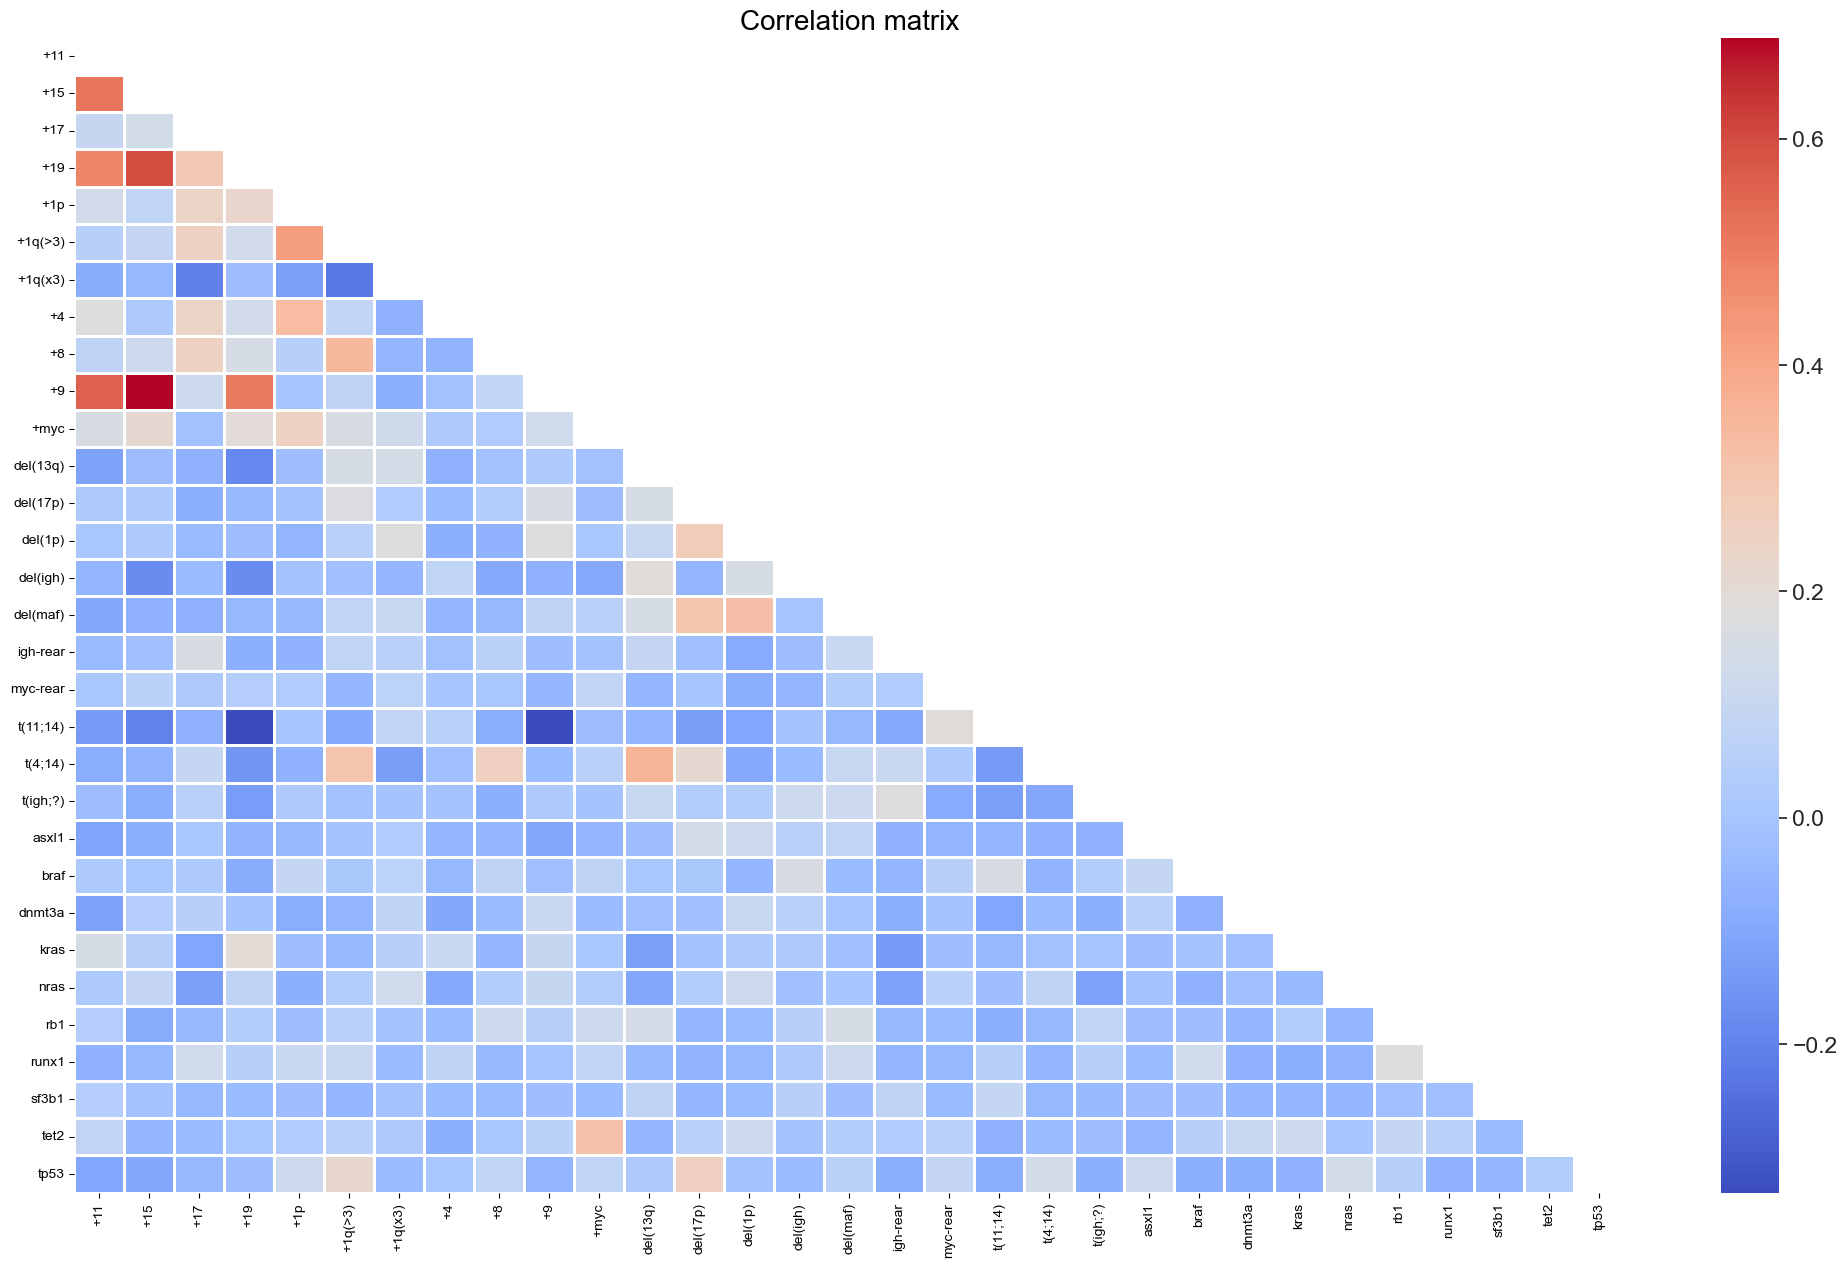

In [33]:
 
mask = np.zeros_like(num_corr_filtered)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

f, ax = plt.subplots(figsize=(25, 15))
sns.set(font_scale=1.5)  

ax = sns.heatmap(num_corr_filtered, mask=mask, annot=False, annot_kws={"size": 20}, linewidths=2, cmap="coolwarm", fmt=".2f", ax=ax) 
ax.set_title("Correlation matrix", fontsize=20)
plt.show()

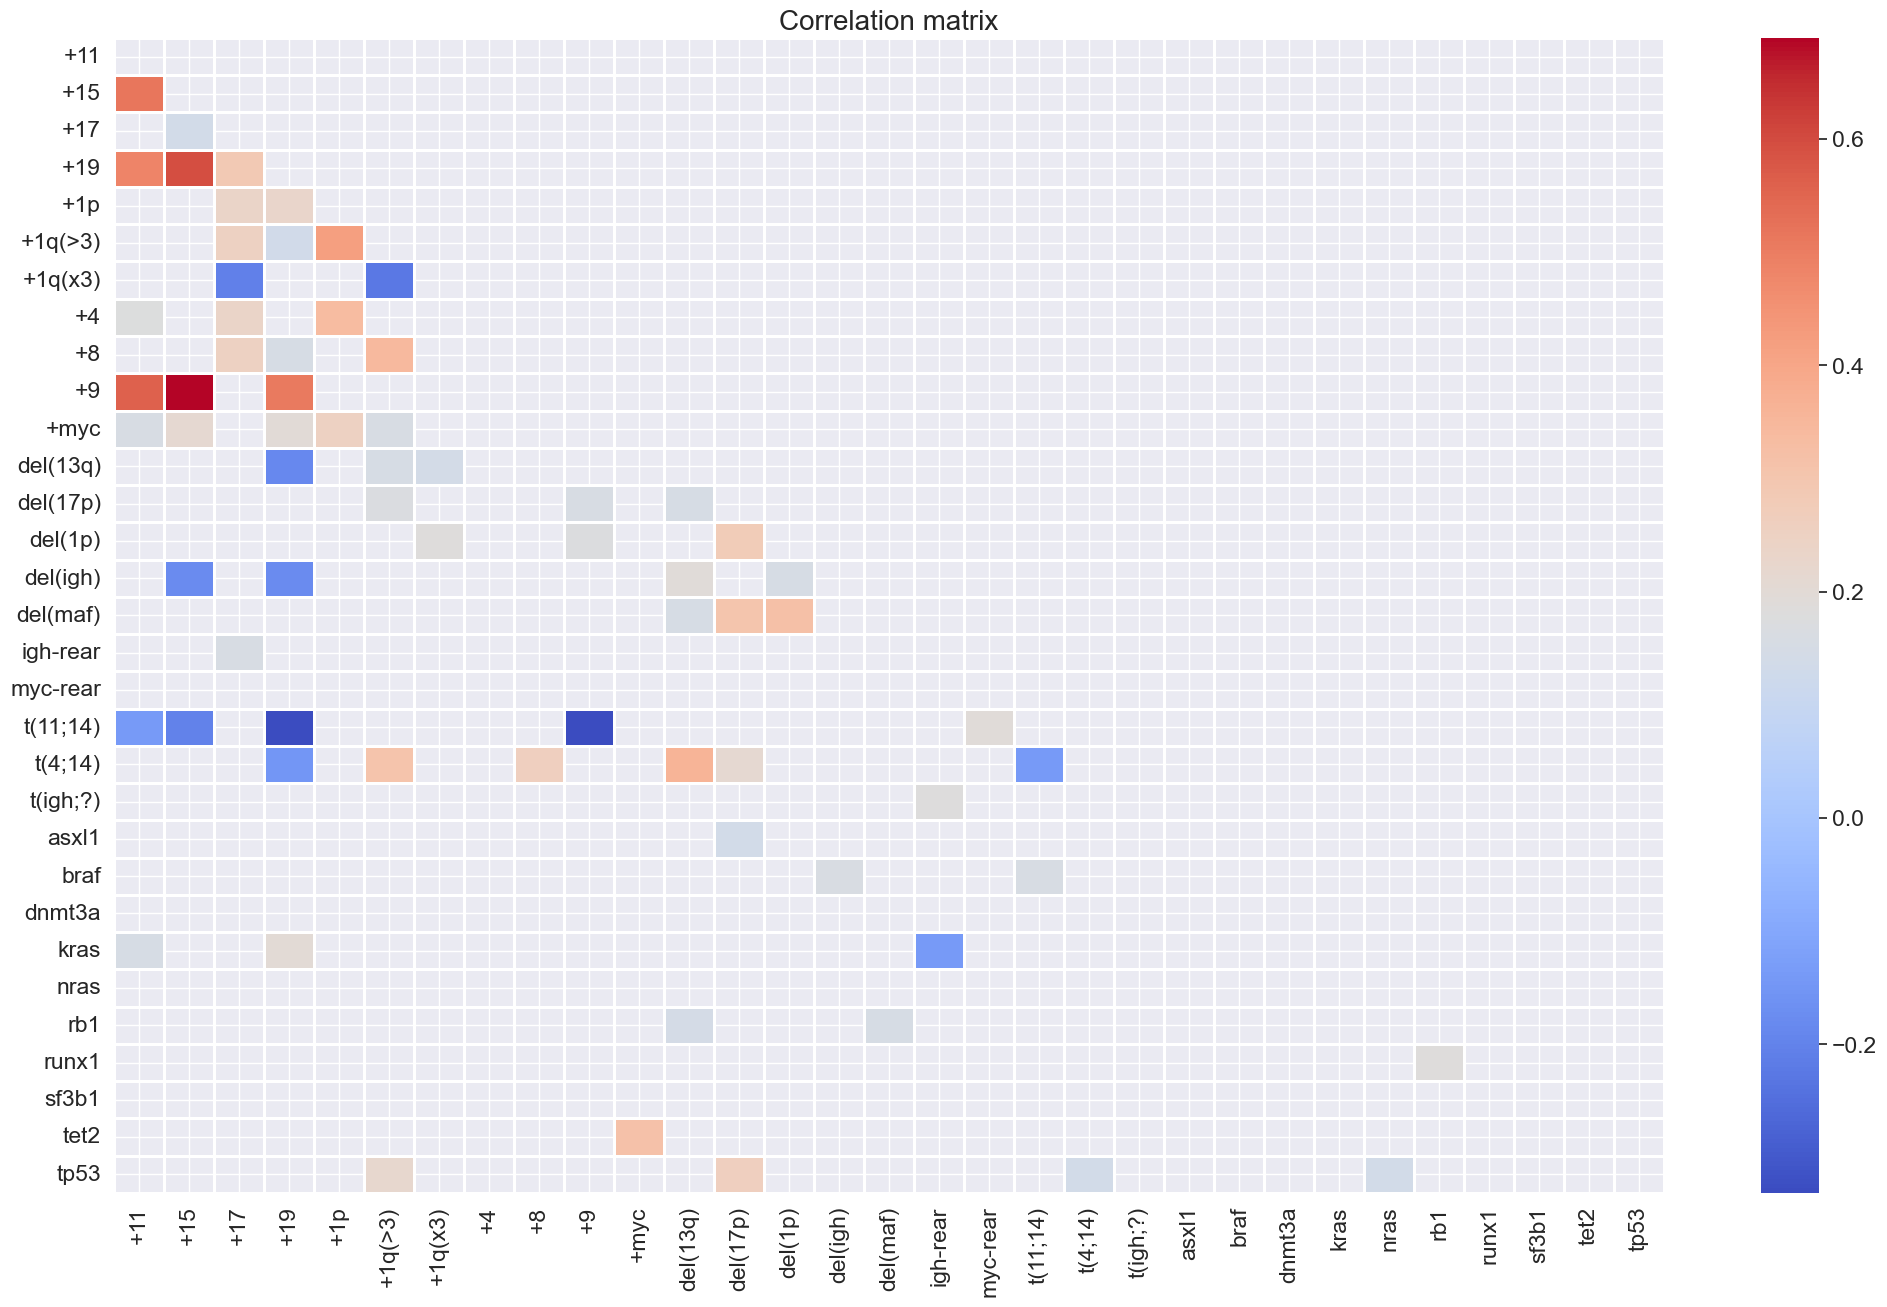

In [34]:
 
mask = np.zeros_like(num_corr_filtered_withp)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

f, ax = plt.subplots(figsize=(25, 15))
sns.set(font_scale=1.5)  

ax = sns.heatmap(num_corr_filtered_withp, mask=mask, annot=False, annot_kws={"size": 20}, linewidths=2, cmap="coolwarm", fmt=".2f", ax=ax) 
ax.set_title("Correlation matrix", fontsize=20)
plt.show()

In [35]:
delt17p_pred = pd.concat([mat1_filtered, mat2_filtered], axis=1)
delt17p_pred = delt17p_pred.dropna()
delt17p_pred = delt17p_pred.astype(bool)
delt17p = delt17p_pred['del(17p)']
delt17p_pred = delt17p_pred.drop(columns=['del(17p)'])
delt17p_pred

,+11,+15,+17,+19,+1p,+1q(>3),+1q(x3),+4,+8,+9,+myc,del(13q),del(1p),del(igh),del(maf),igh-rear,myc-rear,t(11;14),t(4;14),t(igh;?),asxl1,braf,dnmt3a,kras,nras,rb1,runx1,sf3b1,tet2,tp53
0,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,True,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False
3,True,True,True,True,False,True,False,False,True,True,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,True,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
8,False,False,False,False,False,False,False,False,False,True,True,True,False,False,True,True,True,False,True,False,False,False,False,False,False,False,False,False,True,True
9,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [61]:
X_train_17p, X_test_17p, y_train_17p, y_test_17p = train_test_split(delt17p_pred, delt17p, test_size=0.3, random_state=42)

In [62]:
rf = RandomForestClassifier()

# Fit the model on the training data
rf.fit(X_train_17p, y_train_17p)

RandomForestClassifier()

In [63]:
y_pred_rf_17p = rf.predict(X_test_17p)

In [64]:
cm_rf_17p = confusion_matrix(y_test_17p, y_pred_rf_17p)
cm_rf_17p

array([[62,  0],
       [ 1,  2]], dtype=int64)

In [65]:
TN, FP, FN, TP = cm_rf_17p.ravel()

# Calculate sensitivity (recall)
sensitivity = TP / (TP + FN)

# Calculate specificity
specificity = TN / (TN + FP)

print("Sens:", round(sensitivity,2))
print("Spec:", round(specificity,2))

#test size 0.3
#Sens: 0.67
#Spec: 0.98

Sens: 0.67
Spec: 1.0


<Figure size 800x600 with 0 Axes>

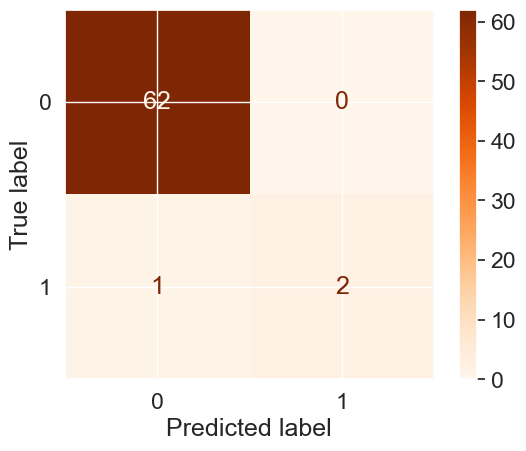

In [78]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_17p)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Oranges')  
plt.grid(True)
plt.show()

In [66]:
X_train_17p_04, X_test_17p_04, y_train_17p_04, y_test_17p_04 = train_test_split(delt17p_pred, delt17p, test_size=0.4, random_state=42)

In [67]:
rf_04 = RandomForestClassifier()

rf_04.fit(X_train_17p_04, y_train_17p_04)

RandomForestClassifier()

In [68]:
y_pred_rf_17p_04 = rf.predict(X_test_17p_04)

In [69]:
cm_rf_17p_04 = confusion_matrix(y_test_17p_04, y_pred_rf_17p_04)
cm_rf_17p_04

array([[79,  0],
       [ 1,  6]], dtype=int64)

In [70]:
TN_04, FP_04, FN_04, TP_04 = cm_rf_17p_04.ravel()

sensitivity_04 = TP_04 / (TP_04 + FN_04)

specificity_04 = TN_04 / (TN_04 + FP_04)

print("Sens:", round(sensitivity_04,2))
print("Spec:", round(specificity_04,2))

#test size 0.4
#Sens: 0.86
#Spec: 1.0

Sens: 0.86
Spec: 1.0


<Figure size 800x600 with 0 Axes>

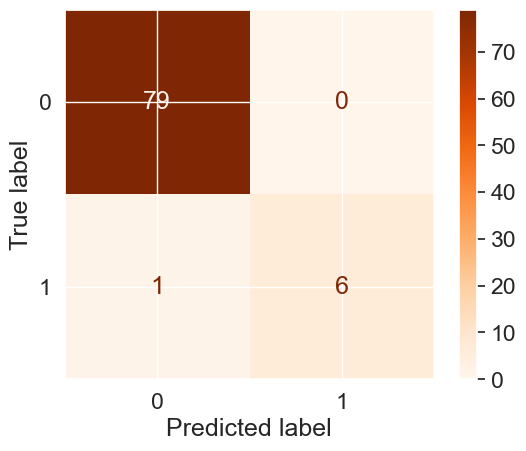

In [77]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_17p_04)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Oranges')  
plt.grid(True)
plt.show()

In [71]:
X_train_17p_02, X_test_17p_02, y_train_17p_02, y_test_17p_02 = train_test_split(delt17p_pred, delt17p, test_size=0.2, random_state=42)

In [72]:
rf_02 = RandomForestClassifier()

rf_02.fit(X_train_17p_02, y_train_17p_02)

RandomForestClassifier()

In [73]:
y_pred_rf_17p_02 = rf.predict(X_test_17p_02)

In [74]:
cm_rf_17p_02 = confusion_matrix(y_test_17p_02, y_pred_rf_17p_02)
cm_rf_17p_02

array([[40,  0],
       [ 1,  2]], dtype=int64)

In [75]:
TN_02, FP_02, FN_02, TP_02 = cm_rf_17p_02.ravel()

sensitivity_02 = TP_02 / (TP_02 + FN_02)

specificity_02 = TN_02 / (TN_02 + FP_02)

print("Sens:", round(sensitivity_02,2))
print("Spec:", round(specificity_02,2))

#test size 0.2
#Sens: 0.67
#Spec: 1.0

Sens: 0.67
Spec: 1.0


<Figure size 800x600 with 0 Axes>

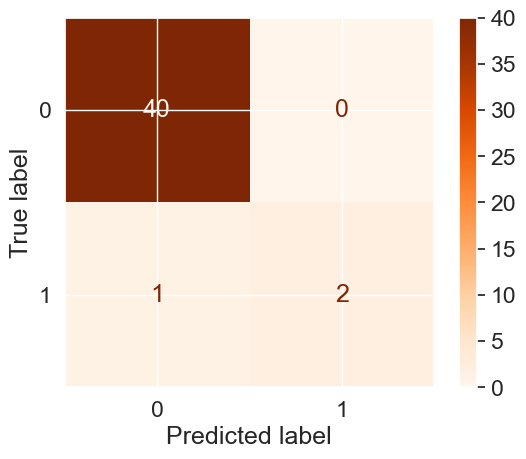

In [76]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_17p_02)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Oranges')  
plt.grid(True)
plt.show()

In [79]:
X_train_17p_05, X_test_17p_05, y_train_17p_05, y_test_17p_05 = train_test_split(delt17p_pred, delt17p, test_size=0.5, random_state=42)

In [80]:
rf_05 = RandomForestClassifier()

rf_05.fit(X_train_17p_05, y_train_17p_05)

RandomForestClassifier()

In [81]:
y_pred_rf_17p_05 = rf.predict(X_test_17p_05)

In [82]:
cm_rf_17p_05 = confusion_matrix(y_test_17p_05, y_pred_rf_17p_05)
cm_rf_17p_05

array([[97,  0],
       [ 1,  9]], dtype=int64)

In [83]:
TN_05, FP_05, FN_05, TP_05 = cm_rf_17p_05.ravel()

sensitivity_05 = TP_05 / (TP_05 + FN_05)

specificity_05 = TN_05 / (TN_05 + FP_05)

print("Sens:", round(sensitivity_05,2))
print("Spec:", round(specificity_05,2))

#test size 0.5
#Sens: 0.9
#Spec: 0.99

Sens: 0.9
Spec: 1.0


<Figure size 800x600 with 0 Axes>

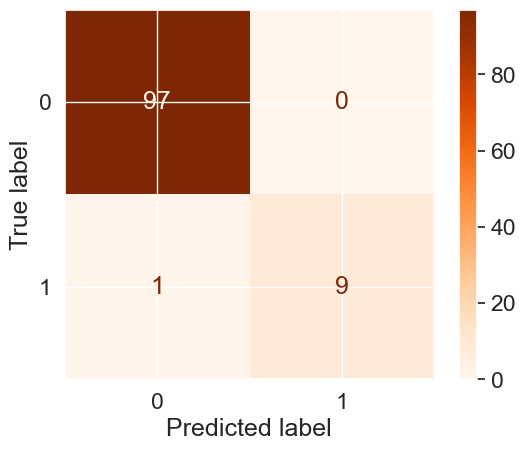

In [84]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_17p_05)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Oranges')  
plt.grid(True)
plt.show()

In [87]:
xgb = XGBClassifier()

In [88]:
xgb.fit(X_train_17p,  y_train_17p)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [93]:
y_pred_xgb_17p = xgb.predict(X_test_17p)
cm_xgb_17p = confusion_matrix(y_test_17p, y_pred_xgb_17p)
cm_xgb_17p

array([[52, 10],
       [ 1,  2]], dtype=int64)

In [94]:
TN_xgb, FP_xgb, FN_xgb, TP_xgb = cm_xgb_17p.ravel()

sensitivity_xgb = TP_xgb / (TP_xgb + FN_xgb)

specificity_xgb = TN_xgb / (TN_xgb + FP_xgb)

print("Sens:", round(sensitivity_xgb,2))
print("Spec:", round(specificity_xgb,2))

#test size 0.3
Sens: 0.67
Spec: 0.84

Sens: 0.67
Spec: 0.84


In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_17p)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Oranges')  
plt.grid(True)
plt.show()

In [95]:
xgb_05 = XGBClassifier()

In [96]:
xgb_05.fit(X_train_17p_05, y_train_17p_05)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [97]:
y_pred_xgb_17p_05 = xgb.predict(X_test_17p_05)
cm_xgb_17p_05 = confusion_matrix(y_test_17p_05, y_pred_xgb_17p_05)
cm_xgb_17p_05

array([[87, 10],
       [ 2,  8]], dtype=int64)

In [98]:
TN_xgb_05, FP_xgb_05, FN_xgb_05, TP_xgb_05 = cm_xgb_17p_05.ravel()

sensitivity_xgb_05 = TP_xgb_05 / (TP_xgb_05 + FN_xgb_05)

specificity_xgb_05 = TN_xgb_05 / (TN_xgb_05 + FP_xgb_05)

print("Sens:", round(sensitivity_xgb_05,2))
print("Spec:", round(specificity_xgb_05,2))

#test size 0.5
#Sens: 0.8
#Spec: 0.9

Sens: 0.8
Spec: 0.9


<Figure size 800x600 with 0 Axes>

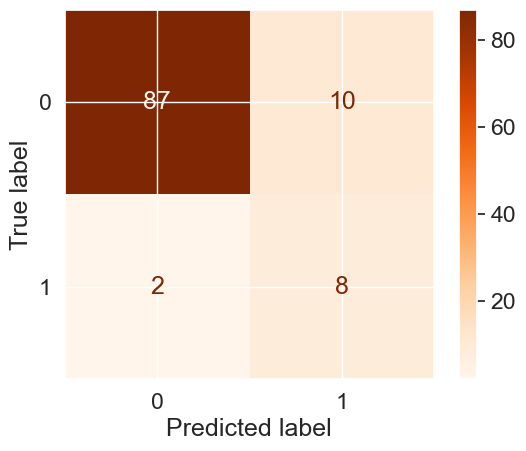

In [99]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_17p_05)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Oranges')  
plt.grid(True)
plt.show()

In [100]:
xgb_04 = XGBClassifier()

In [101]:
xgb_04.fit(X_train_17p_04, y_train_17p_04)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [102]:
y_pred_xgb_17p_04 = xgb.predict(X_test_17p_04)
cm_xgb_17p_04 = confusion_matrix(y_test_17p_04, y_pred_xgb_17p_04)
cm_xgb_17p_04

array([[69, 10],
       [ 2,  5]], dtype=int64)

In [103]:
TN_xgb_04, FP_xgb_04, FN_xgb_04, TP_xgb_04 = cm_xgb_17p_04.ravel()

sensitivity_xgb_04 = TP_xgb_04 / (TP_xgb_05 + FN_xgb_04)

specificity_xgb_04 = TN_xgb_04 / (TN_xgb_05 + FP_xgb_04)

print("Sens:", round(sensitivity_xgb_04,2))
print("Spec:", round(specificity_xgb_04,2))

#test size 0.4
#Sens: 0.5
#Spec: 0.71

Sens: 0.5
Spec: 0.71


<Figure size 800x600 with 0 Axes>

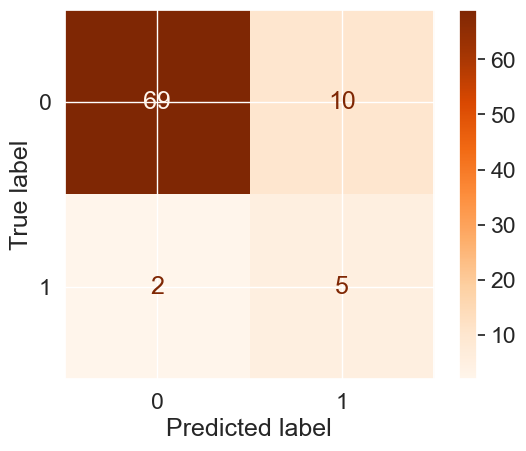

In [104]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_17p_04)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Oranges')  
plt.grid(True)
plt.show()

In [105]:
xgb_02 = XGBClassifier()

In [106]:
xgb_02.fit(X_train_17p_02, y_train_17p_02)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [107]:
y_pred_xgb_17p_02 = xgb.predict(X_test_17p_02)
cm_xgb_17p_02 = confusion_matrix(y_test_17p_02, y_pred_xgb_17p_02)
cm_xgb_17p_02

array([[33,  7],
       [ 1,  2]], dtype=int64)

In [108]:
TN_xgb_02, FP_xgb_02, FN_xgb_02, TP_xgb_02 = cm_xgb_17p_02.ravel()

sensitivity_xgb_02 = TP_xgb_02 / (TP_xgb_05 + FN_xgb_02)

specificity_xgb_02 = TN_xgb_02 / (TN_xgb_05 + FP_xgb_02)

print("Sens:", round(sensitivity_xgb_02,2))
print("Spec:", round(specificity_xgb_02,2))

#test size 0.2
#Sens: 0.22
#Spec: 0.35

Sens: 0.22
Spec: 0.35


<Figure size 800x600 with 0 Axes>

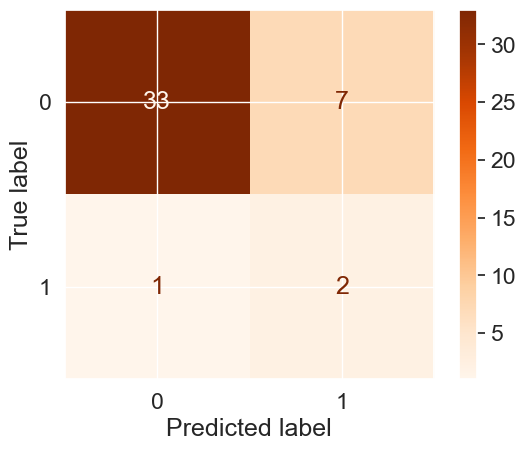

In [109]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_17p_02)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Oranges')  
plt.grid(True)
plt.show()

In [110]:
###APPLYING SMOTE###
delt17p_pred_int = delt17p_pred.astype(int)
delt17p_int = delt17p.astype(int)
X_train_17p_int, X_test_17p_int, y_train_17p_int, y_test_17p_int = train_test_split(delt17p_pred_int, delt17p_int, test_size=0.4, random_state=42)
smote = SMOTE(random_state=42)
X_train_17p_int_res, y_train_17p_int_res = smote.fit_resample(X_train_17p_int, y_train_17p_int)

In [111]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_17p_int_res, y_train_17p_int_res)

y_pred_17p_int_res_rf = model.predict(X_test_17p_int)

In [112]:
cm_rf_17p_res = confusion_matrix(y_test_17p_int, y_pred_17p_int_res_rf)
cm_rf_17p_res

array([[52, 27],
       [ 5,  2]], dtype=int64)

<Figure size 800x600 with 0 Axes>

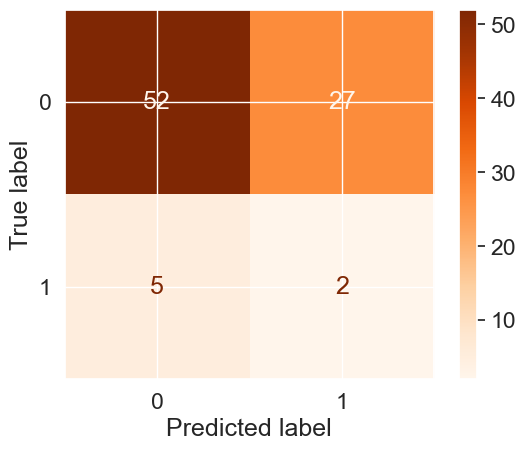

In [113]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_17p_res)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Oranges')  
plt.grid(True)
plt.show()

In [114]:
TN_res, FP_res, FN_res, TP_res = cm_rf_17p_res.ravel()

# Calculate sensitivity (recall)
sensitivity_res = TP_res / (TP_res + FN_res)

# Calculate specificity
specificity_res = TN_res / (TN_res + FP_res)

print("Sens:", round(sensitivity_res,2))
print("Spec:", round(specificity_res,2))

#test size 0.4
#Sens: 0.29
#Spec: 0.66

Sens: 0.29
Spec: 0.66
